## Datahandling
- `Dataset`:PyTorch-Basisklasse für eigene Datensätze (`from torch.utils.data import Dataset`).
  - Damit DataLoader später damit arbeiten kann (`len(dataset), dataset[i]`).
- `self.mnist = datasets.MNIST()`: Hier wird das dataset gespeichert.
Die Argumente von datasets.MNIST:
- `root="./data"` → Ordner, wo MNIST liegt/hingeladen wird.
- `train=train`: Mit `True` bekommt man den Trainingssplit.
- `download=True`: Lädt automatisch, falls es noch nicht da ist.
- `transform=transforms.ToTensor()`: Funktion bereitgestellt um aus PIL-Imnage einen Tensor der Form (1, 28, 28) zu erzeugen.
- `self.pool = nn.MaxPool2d(kernel_size=2, stride=2)`: Downsampling mit halbierung der Dimension

- `len(train_ds)` ruft intern `train_ds.__len__()` auf.
- Wenn `__len__` nicht definiert ist, weiß Python (und der DataLoader) nicht, wie viele Elemente das `MnistSuperRes`-Objekt hat.

- Wenn `dataset[i]` aufgerufen wird, landet das hier.
- `self.mnist[idx]` gibt:
  - `img`: Tensor (1, 28, 28) → das Original-MNIST-Bild in hoher Auflösung.
  - `label`: Ziffer 0–9 (hier irrelevant).

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

class MnistSuperRes(Dataset):
    def __init__(self, train=True):
        self.mnist = datasets.MNIST(
            root="./data",
            train=train,
            download=True,
            transform=transforms.ToTensor()
        )
        # MaxPool2d für Downsampling der Trainingsdaten
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]   # img: (1, 28, 28)
        low_res = self.pool(img)       # (1,14,14)
        high_res = img                 # (1,28,28)
        return low_res, high_res


In [20]:
train_ds = MnistSuperRes(train=True)
test_ds  = MnistSuperRes(train=False)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


## Upscaling Layer
- `in_channels=1`: Input Kanal mit Graustufen (14x14)
- `out_channels=32`: Output Kanal mit 32 Feature-Maps
- Kombination aus `kernel_size=4, stride=2, padding=1` macht aus (14x14) -> (28x28)
- Output-Shape: `(B, 32, 28, 28)`

In [21]:
import torch.nn as nn

class SimpleSRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 1x14x14 -> 32x28x28
        self.up = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1
        )
        # ein paar Convs auf 28x28
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # 28x28 weil padding=1
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1) # 28x28 weil padding=1
        self.conv3 = nn.Conv2d(16, 1,  kernel_size=3, padding=1) # 28x28 weil padding=1

        self.act = nn.ReLU()

    def forward(self, x):   # (B, 1, 14, 14)
        
        x = self.up(x)      # (B, 32, 28, 28)
        x = self.act(x)
        x = self.conv1(x)   # (B, 32, 28, 28)
        x = self.act(x)
        x = self.conv2(x)   # (B, 16, 28, 28)
        x = self.act(x)
        x = self.conv3(x)   # (B, 1, 28, 28)
        x = torch.sigmoid(x)
        
        return x            # (B, 1, 28, 28)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleSRCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for low_res, high_res in train_loader:
        low_res  = low_res.to(device)   # (B,1,14,14)
        high_res = high_res.to(device)  # (B,1,28,28)

        optimizer.zero_grad()
        outputs = model(low_res)        # (B,1,28,28)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * low_res.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


Epoch 1/5, Train Loss: 0.0145
Epoch 2/5, Train Loss: 0.0063


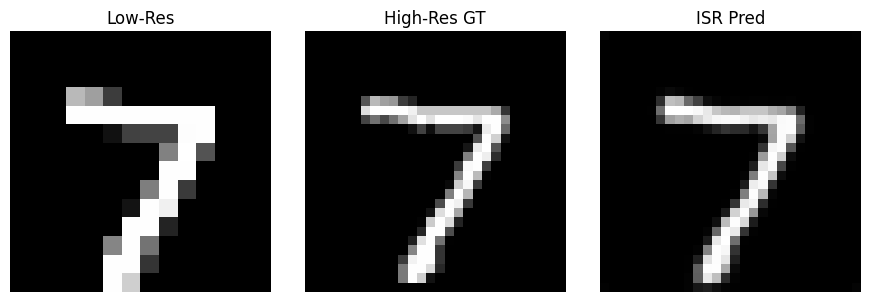

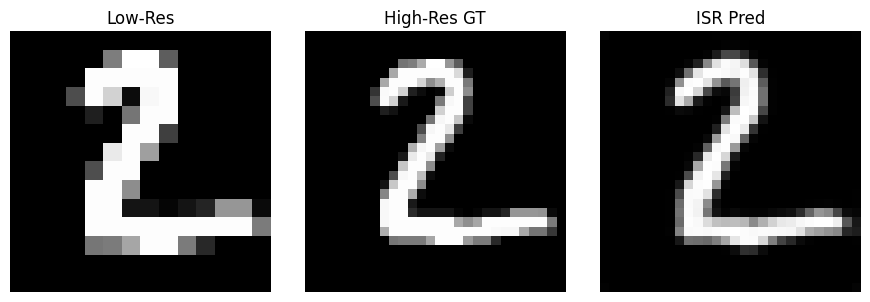

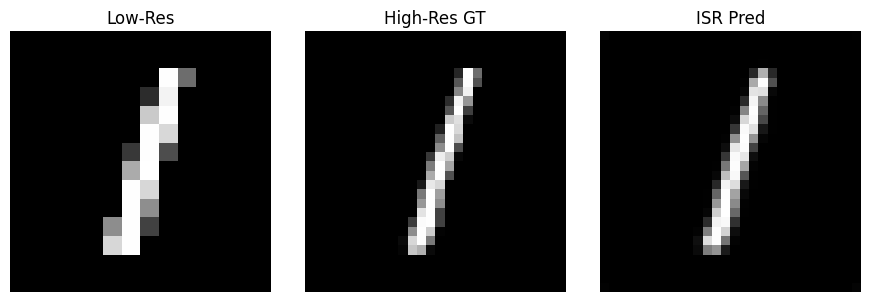

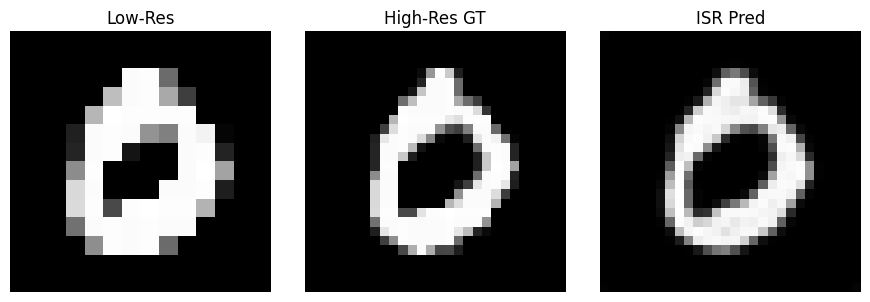

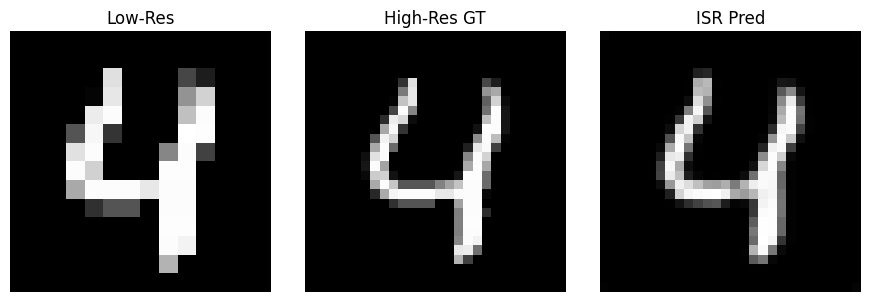

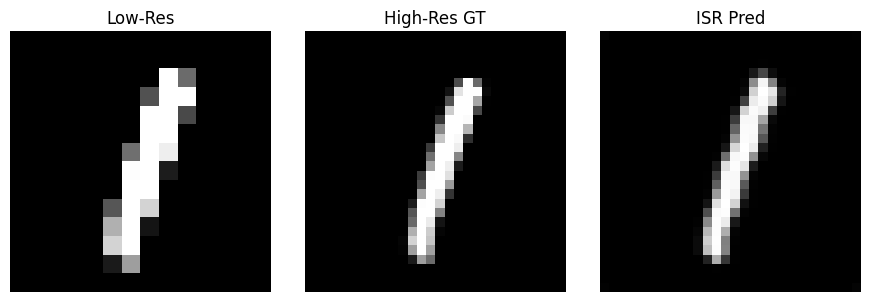

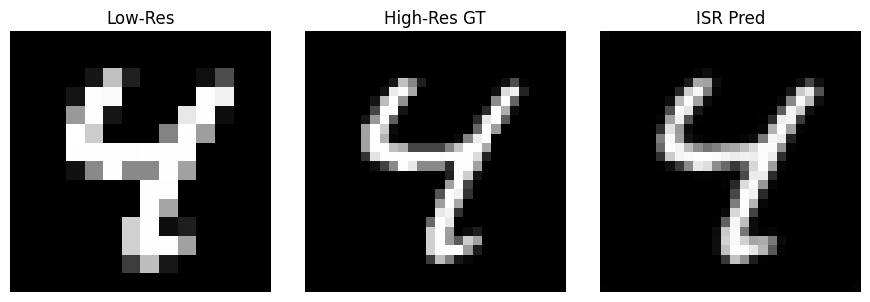

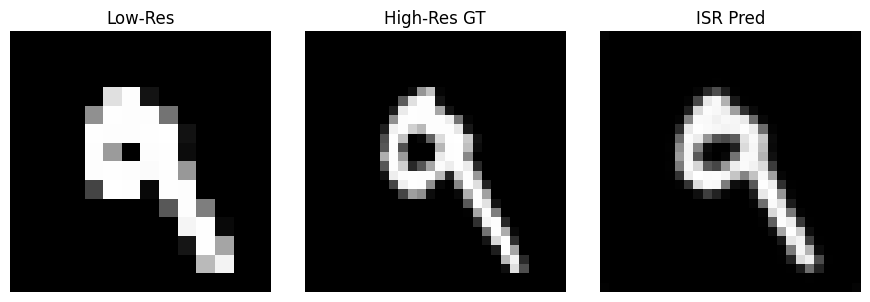

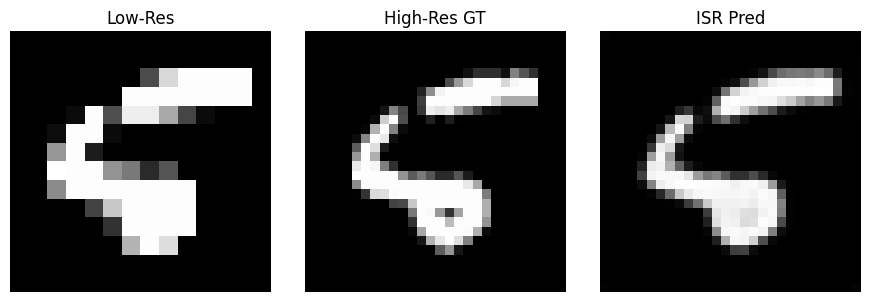

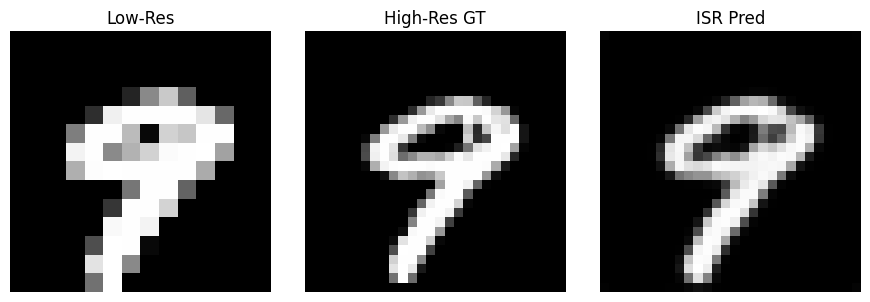

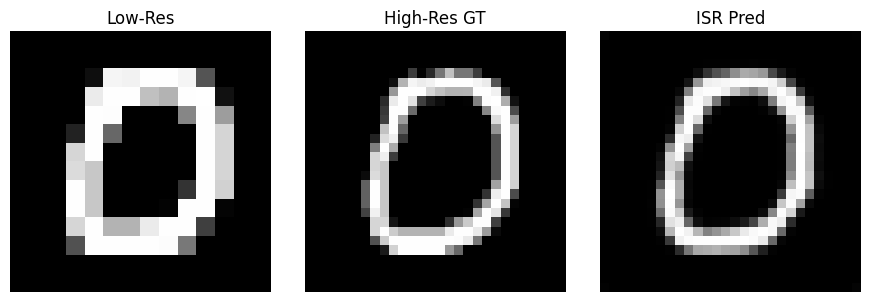

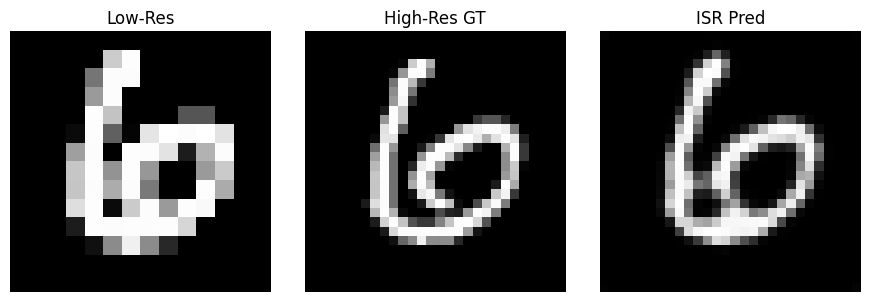

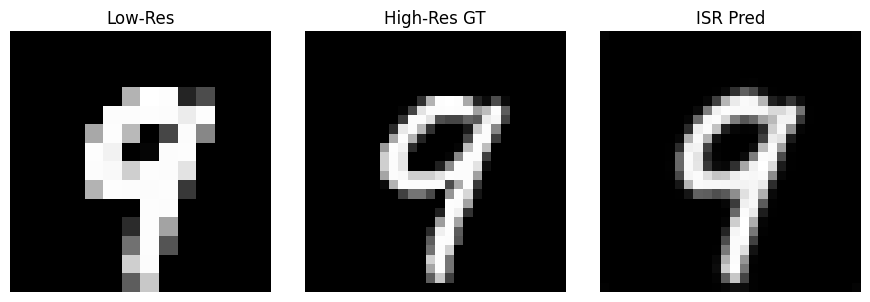

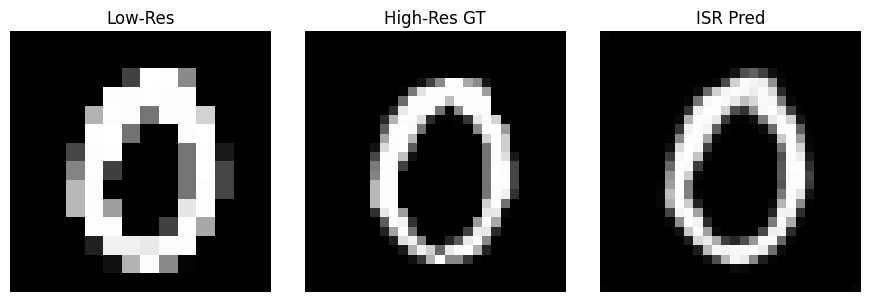

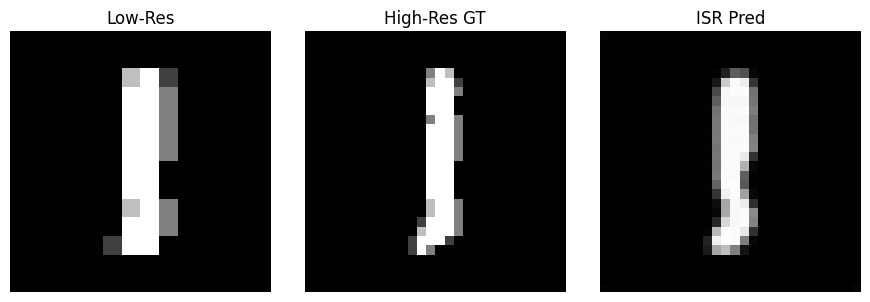

In [ ]:
import matplotlib.pyplot as plt

model.eval()
low_res, high_res = next(iter(test_loader))
low_res  = low_res.to(device)
high_res = high_res.to(device)

with torch.no_grad():
    preds = model(low_res)

for i in range(15):
    lr  = low_res[i, 0].cpu().numpy()
    hr  = high_res[i, 0].cpu().numpy()
    pr  = preds[i, 0].cpu().numpy()
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.title("Low-Res");  plt.imshow(lr, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("High-Res GT"); plt.imshow(hr, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("ISR Pred"); plt.imshow(pr, cmap="gray"); plt.axis("off")
    plt.tight_layout()
    plt.show()
